In [25]:
# Auxiliar imports
import sys, os, time, importlib
import matplotlib.pyplot as plt
import numpy as np

# Gym imports
import gym
from gym.vector import SyncVectorEnv

# PyTorch imports
import torch
from torch import nn, optim

# Custom imports
sys.path.append(os.path.abspath('..')) # Add parent directory to path

import ppo_network
importlib.reload(ppo_network) # Prevents caching issues with notebooks
from ppo_network import PPONetworkDiscrete

import ppo
importlib.reload(ppo) # Prevents caching issues with notebooks
from ppo import PPODiscrete

import hp_tuner
importlib.reload(hp_tuner) # Prevents caching issues with notebooks
from hp_tuner import HPTuner

In [26]:
# CartPole environment
env_id = 'CartPole-v1'
max_episode_steps = 1024
num_envs = 16

# Environment kwargs
env_kwargs = {
    'id': env_id,
    'max_episode_steps': max_episode_steps,
}

# Create vectorized environment
envs_vector = SyncVectorEnv([lambda: gym.make(**env_kwargs)] * num_envs)
states, infos = envs_vector.reset()

In [27]:
# Policy-Value Network
network_kwargs = {
    'input_dims': 4,
    'output_dims': 2,
    'shared_hidden_dims': [512, 256, 128],
    'shared_activation': nn.ReLU,
    'policy_hidden_dims': [64, 64],
    'policy_activation': nn.ReLU,
    'value_hidden_dims': [64, 64],
    'value_activation': nn.ReLU,
    #'debug_prints': True,
}

# Create policy-value network
network = PPONetworkDiscrete(**network_kwargs)

In [28]:
# Test forward pass
for _ in range(3):
    states_tensor = torch.tensor(states, dtype=torch.float32)
    policy, value = network(states_tensor)
    
    actions_dist = torch.distributions.Categorical(logits=policy)
    actions = actions_dist.sample().numpy()
    
    states, rewards, dones, truncateds, infos = envs_vector.step(actions)
    print(f"State: {states[0]}"[:80])

State: [-0.01300412  0.23786896  0.00837785 -0.30681843]
State: [-0.00824674  0.04262865  0.00224148 -0.01150516]
State: [-0.00739417 -0.15252538  0.00201138  0.28188413]


In [29]:
# PPO hyperparameters
ppo_kwargs = {
    'network_class': PPONetworkDiscrete,
    'network_kwargs': network_kwargs,
    'num_envs': num_envs,
    'lr': 3e-4,
    'final_lr': 1e-6,
    'gamma': 0.99,
    'lam': 0.99,
    'clip_eps': 0.25,
    'final_clip_eps': 0.01,
    'value_coef': 0.7,
    'entropy_coef': 0.2,
    'final_entropy_coef': 0.01,
    'batch_size': 1024,
    'mini_batch_size': 128,
    'batch_epochs': 8,
    'batch_shuffle': True,
    'reward_normalization': True,
    'truncated_reward': 5,
    'debug_prints': False,   
}

ppo = PPODiscrete(envs_vector, **ppo_kwargs)

# Test PPO training
ppo.train(1)

array([140.75])

Optimizing reward_normalization with values: [True, False]
Running trials for reward_normalization = True
Running trials for reward_normalization = False
Best value for reward_normalization: False


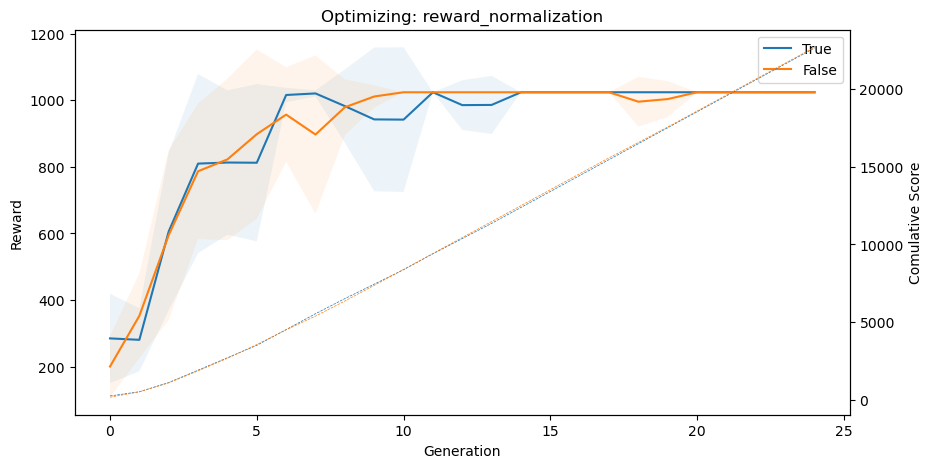

Optimizing batch_size with values: [724, 1024, 1448]
Running trials for batch_size = 724
Skipping batch_size = 1024, score: 22670.71
Running trials for batch_size = 1448
Best value for batch_size: 1448


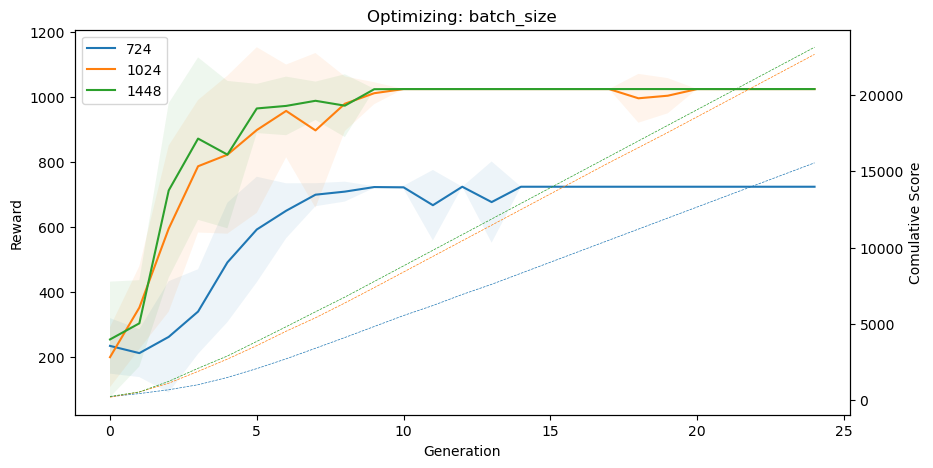

Optimizing batch_shuffle with values: [True, False]
Skipping batch_shuffle = True, score: 23139.22
Running trials for batch_shuffle = False
Best value for batch_shuffle: True
No change in batch_shuffle, no change ratio: 0.33


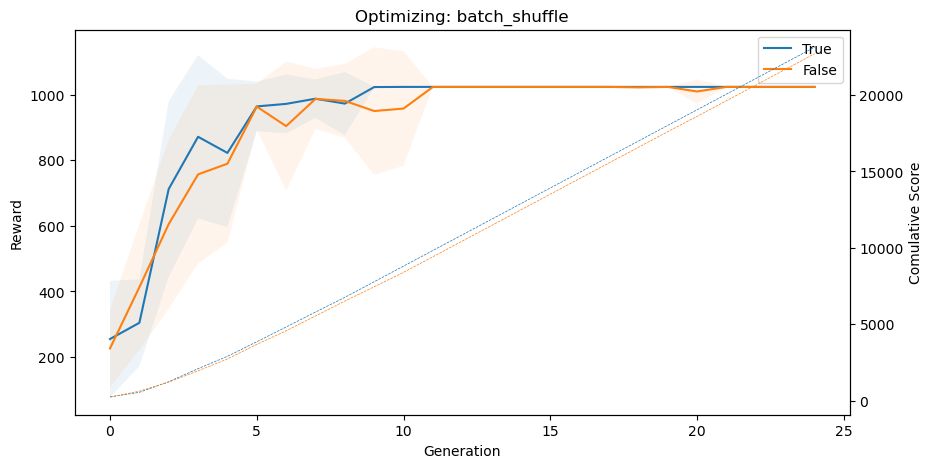

Optimizing reward_normalization with values: [False, True]
Skipping reward_normalization = False, score: 23139.22
Running trials for reward_normalization = True
Best value for reward_normalization: False
No change in reward_normalization, no change ratio: 0.67


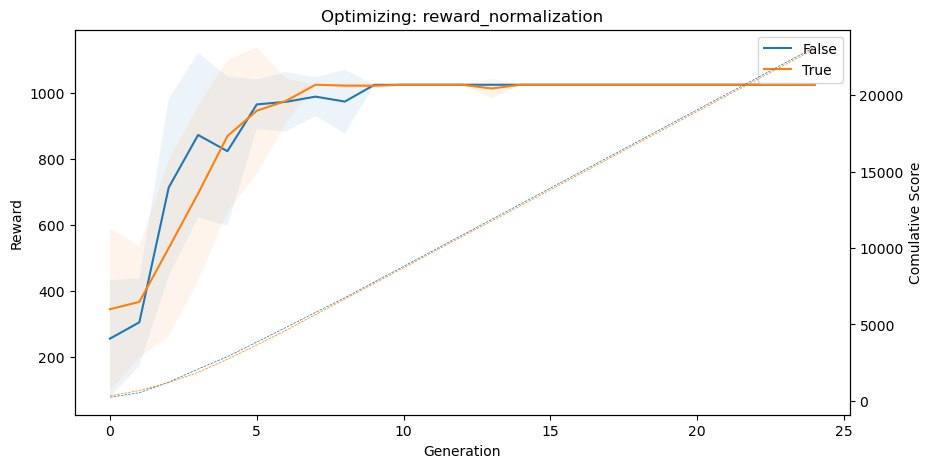

Optimizing batch_size with values: [1024, 1448, 2048]
Skipping batch_size = 1024, score: 22670.71
Skipping batch_size = 1448, score: 23139.22
Running trials for batch_size = 2048


In [ ]:
# Hyperparameter tuning
hp_tuner = HPTuner(
    env_kwargs=env_kwargs,
    num_envs=num_envs,
    ppo_class=PPODiscrete,
    ppo_kwargs=ppo_kwargs,
)

# Define hyperparameters to optimize
parameters = [
    'reward_normalization',
    'mini_batch_size', 
    'batch_shuffle',
    ]

# Optimize hyperparameters
evolutions = hp_tuner.optimize_hyperparameters(
    parameters, generations=25, num_trials = 8,
    )

# Create video
hp_tuner.evolution_video(
    generations=25, video_folder = 'videos', increments=5, max_frames=max_episode_steps,
    )